In [54]:
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
import seaborn as sn
import os
import pathlib

from PIL import Image
from sklearn.datasets import load_files
from sklearn.model_selection import train_test_split
from keras.utils import np_utils
from numpy import asarray
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential

from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

# Check for TensorFlow GPU access
print(tf.config.list_physical_devices())

# See TensorFlow version
print(tf.__version__)

[PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU'), PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]
2.9.2


In [55]:
base_dir = '../data/fruits-360/'
test_dir = os.path.join(base_dir, 'Test')
train_dir = os.path.join(base_dir, 'Training')

In [56]:
train_img_count = sum(len(files) for _, _, files in os.walk(train_dir))
test_img_count = sum(len(files) for _, _, files in os.walk(test_dir))

print(f'Number of files in the training folder: {train_img_count}')
print(f'Number of files in the test folder: {test_img_count}\n')

nr_classes = sorted((f for f in os.listdir(train_dir) if not f.startswith(".")), key=str.lower)

print(f'Number of classes: {len(nr_classes)}')
print(f'Names of classes: {nr_classes}')

Number of files in the training folder: 67693
Number of files in the test folder: 22688

Number of classes: 131
Names of classes: ['Apple Braeburn', 'Apple Crimson Snow', 'Apple Golden 1', 'Apple Golden 2', 'Apple Golden 3', 'Apple Granny Smith', 'Apple Pink Lady', 'Apple Red 1', 'Apple Red 2', 'Apple Red 3', 'Apple Red Delicious', 'Apple Red Yellow 1', 'Apple Red Yellow 2', 'Apricot', 'Avocado', 'Avocado ripe', 'Banana', 'Banana Lady Finger', 'Banana Red', 'Beetroot', 'Blueberry', 'Cactus fruit', 'Cantaloupe 1', 'Cantaloupe 2', 'Carambula', 'Cauliflower', 'Cherry 1', 'Cherry 2', 'Cherry Rainier', 'Cherry Wax Black', 'Cherry Wax Red', 'Cherry Wax Yellow', 'Chestnut', 'Clementine', 'Cocos', 'Corn', 'Corn Husk', 'Cucumber Ripe', 'Cucumber Ripe 2', 'Dates', 'Eggplant', 'Fig', 'Ginger Root', 'Granadilla', 'Grape Blue', 'Grape Pink', 'Grape White', 'Grape White 2', 'Grape White 3', 'Grape White 4', 'Grapefruit Pink', 'Grapefruit White', 'Guava', 'Hazelnut', 'Huckleberry', 'Kaki', 'Kiwi', 'K

<Figure size 1000x1000 with 0 Axes>

Text(0.5, 1.0, 'Kiwi')

(-0.5, 99.5, 99.5, -0.5)

Text(0.5, 1.0, 'Pear')

(-0.5, 99.5, 99.5, -0.5)

Text(0.5, 1.0, 'Peach')

(-0.5, 99.5, 99.5, -0.5)

Text(0.5, 1.0, 'Avocado')

(-0.5, 99.5, 99.5, -0.5)

Text(0.5, 1.0, 'Blueberry')

(-0.5, 99.5, 99.5, -0.5)

Text(0.5, 1.0, 'Tomato 3')

(-0.5, 99.5, 99.5, -0.5)

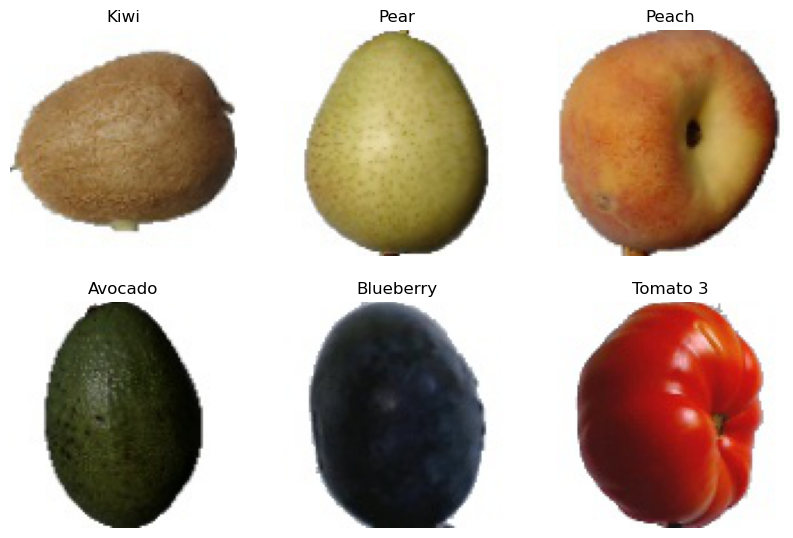

In [57]:
train_dir = pathlib.Path(train_dir)
test_dir = pathlib.Path(test_dir)

fruit6 = ['Kiwi', 'Pear', 'Peach', 'Avocado', 'Blueberry', 'Tomato 3']

plt.figure(figsize=(10, 10))

for i,fruit in enumerate (fruit6):    
    ax = plt.subplot(3, 3, i + 1)
    
    fruit_list = list(train_dir.glob(fruit + '/*'))
    
    plt.imshow(Image.open(str(fruit_list[i])))
    plt.title(fruit6[i])
    plt.axis("off")    

In [58]:
# Loading the dataset

def load_fruits360(path):
    data_loading = load_files(path)
    files = np.array(data_loading['filenames'])
    target_fruits = np.array(data_loading['target'])
    target_labels_fruits = np.array(data_loading['target_names'])
    
    return files, target_fruits, target_labels_fruits

X_train, y_train, target_labels = load_fruits360(train_dir)
X_test, y_test, _ = load_fruits360(test_dir)

In [59]:
print(f'Number of classes: {len(np.unique(y_train))}')

X_train.shape
y_train.shape
X_test.shape
y_test.shape

Number of classes: 131


(67692,)

(67692,)

(22688,)

(22688,)

In [61]:
# Splitting the test set into validation and test set (ratio 1/2)

#X_test, X_valid = X_test[11344:],X_test[:11344]
#y_test, y_vaild = y_test[11344:],y_test[:11344]

# Splitting the training set into validation and training set (10000 validation)

X_train, X_valid, y_train, y_valid  = train_test_split(X_train, y_train, test_size = 0.20, random_state = 1)

(43322,)

(43322,)

(22688,)

(22688,)

In [62]:
def convert_image_to_nparray(files):
    images = []
    for file in files:
        images.append(asarray(Image.open(file)))
    return images

X_train = np.array(convert_image_to_nparray(X_train))
print(f'Training set shape: {X_train.shape}')

X_valid = np.array(convert_image_to_nparray(X_valid))
print(f'Validation set shape: {X_valid.shape}')

X_test = np.array(convert_image_to_nparray(X_test))
print(f'Test set shape: {X_test.shape}')


Training set shape: (43322, 100, 100, 3)
Validation set shape: (10831, 100, 100, 3)
Test set shape: (22688, 100, 100, 3)


In [63]:
# Nr classes, image height and width

num_classes = len(target_labels)

img_height = 100
img_width = 100

In [65]:
# Create the model 

model = Sequential([
  layers.Rescaling(1./255, input_shape=(img_height, img_width, 3)),
  layers.Conv2D(16, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Dropout(0.2),
  layers.Flatten(),
  layers.Dense(128, activation='relu'),
  layers.Dense(num_classes)
])

In [66]:
# Compile the model

model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [67]:
# Model summary

model.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling_4 (Rescaling)     (None, 100, 100, 3)       0         
                                                                 
 conv2d_12 (Conv2D)          (None, 100, 100, 16)      448       
                                                                 
 max_pooling2d_12 (MaxPoolin  (None, 50, 50, 16)       0         
 g2D)                                                            
                                                                 
 conv2d_13 (Conv2D)          (None, 50, 50, 32)        4640      
                                                                 
 max_pooling2d_13 (MaxPoolin  (None, 25, 25, 32)       0         
 g2D)                                                            
                                                                 
 conv2d_14 (Conv2D)          (None, 25, 25, 64)       

In [68]:
# Train the model

history = model.fit(
  X_train, # Train images
  y_train, # Train labels
  batch_size = 32,
  epochs = 10,
  validation_data = (X_valid, y_valid), # Validation images & labels
)


Epoch 1/10


2022-11-22 14:31:25.467664: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


1354/1354 [==============================] - ETA: 0s - loss: 0.6053 - accuracy: 0.8468

2022-11-22 14:31:52.923028: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


1354/1354 [==============================] - 31s 23ms/step - loss: 0.6053 - accuracy: 0.8468 - val_loss: 0.1588 - val_accuracy: 0.9619
Epoch 2/10
1354/1354 [==============================] - 29s 22ms/step - loss: 0.0564 - accuracy: 0.9832 - val_loss: 0.0189 - val_accuracy: 0.9942
Epoch 3/10
1354/1354 [==============================] - 29s 22ms/step - loss: 0.0344 - accuracy: 0.9897 - val_loss: 0.0093 - val_accuracy: 0.9969
Epoch 4/10
1354/1354 [==============================] - 29s 22ms/step - loss: 0.0303 - accuracy: 0.9914 - val_loss: 0.0088 - val_accuracy: 0.9969
Epoch 5/10
1354/1354 [==============================] - 29s 22ms/step - loss: 0.0234 - accuracy: 0.9929 - val_loss: 0.0026 - val_accuracy: 0.9994
Epoch 6/10
1354/1354 [==============================] - 29s 21ms/step - loss: 0.0285 - accuracy: 0.9922 - val_loss: 0.0378 - val_accuracy: 0.9880
Epoch 7/10
1354/1354 [==============================] - 29s 21ms/step - loss: 0.0235 - accuracy: 0.9941 - val_loss: 0.0087 - val_accura

709/709 [==============================] - 7s 10ms/step - loss: 0.3082 - accuracy: 0.9346
Test accuracy: 0.935


<Figure size 1600x800 with 0 Axes>

<AxesSubplot:>

Text(0.5, 1.0, 'Training and Validation Accuracy')

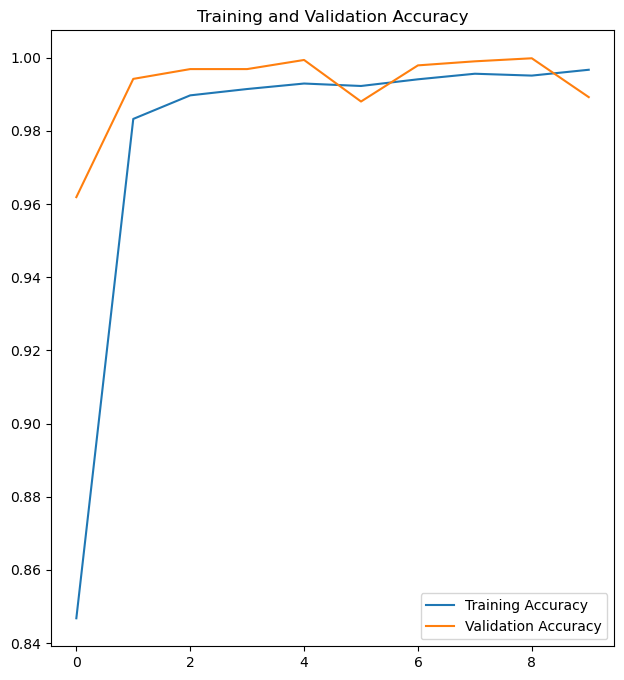

In [69]:
# Accuracy on test set

accuracy = model.evaluate(X_test, y_test) # Test the model
print(f'Test accuracy: {accuracy[1]:.3f}')

acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

epochs_range = range(10)

plt.figure(figsize=(16, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

In [70]:
# Save model

model.save('../models/cnn-split-train-val')

INFO:tensorflow:Assets written to: ../models/cnn-split-train-val/assets


INFO:tensorflow:Assets written to: ../models/cnn-split-train-val/assets


In [77]:
# Convert the model to tflite
converter = tf.lite.TFLiteConverter.from_keras_model(model)
tflite_model = converter.convert()

# Save the model
with open('models.tflite', 'wb') as f:
  f.write(tflite_model)

INFO:tensorflow:Assets written to: /var/folders/k9/jw74cb8j73v296zwvtby70ww0000gn/T/tmpmv98hblo/assets


INFO:tensorflow:Assets written to: /var/folders/k9/jw74cb8j73v296zwvtby70ww0000gn/T/tmpmv98hblo/assets
2022-11-22 14:43:30.967989: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:362] Ignored output_format.
2022-11-22 14:43:30.968147: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:365] Ignored drop_control_dependency.
2022-11-22 14:43:30.971658: I tensorflow/cc/saved_model/reader.cc:43] Reading SavedModel from: /var/folders/k9/jw74cb8j73v296zwvtby70ww0000gn/T/tmpmv98hblo
2022-11-22 14:43:30.974655: I tensorflow/cc/saved_model/reader.cc:81] Reading meta graph with tags { serve }
2022-11-22 14:43:30.974662: I tensorflow/cc/saved_model/reader.cc:122] Reading SavedModel debug info (if present) from: /var/folders/k9/jw74cb8j73v296zwvtby70ww0000gn/T/tmpmv98hblo
2022-11-22 14:43:30.980110: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:354] MLIR V1 optimization pass is not enabled
2022-11-22 14:43:30.981671: I tensorflow/cc/saved_model/load

4885020

In [ ]:
# Predictions

# model = keras.models.load_model('../models/cnn') # Load model

predictions = model.predict(X_test)

Text(0.5, 1.0, 'Nut Forest, Confidence: 100.00')

Text(0.5, 1.0, 'Dates, Confidence: 100.00')

Text(0.5, 1.0, 'Dates, Confidence: 100.00')

Text(0.5, 1.0, 'Fig, Confidence: 100.00')

Text(0.5, 1.0, 'Cauliflower, Confidence: 79.08')

Text(0.5, 1.0, 'Limes, Confidence: 100.00')

Text(0.5, 1.0, 'Pear Stone, Confidence: 100.00')

Text(0.5, 1.0, 'Tomato 2, Confidence: 100.00')

Text(0.5, 1.0, 'Pear Forelle, Confidence: 99.87')

Text(0.5, 1.0, 'Apple Golden 3, Confidence: 99.98')

Text(0.5, 1.0, 'Hazelnut, Confidence: 100.00')

Text(0.5, 1.0, 'Pear Red, Confidence: 100.00')

Text(0.5, 1.0, 'Grape White, Confidence: 100.00')

Text(0.5, 1.0, 'Maracuja, Confidence: 100.00')

Text(0.5, 1.0, 'Apple Red Yellow 2, Confidence: 100.00')

Text(0.5, 1.0, 'Grape White 3, Confidence: 96.85')

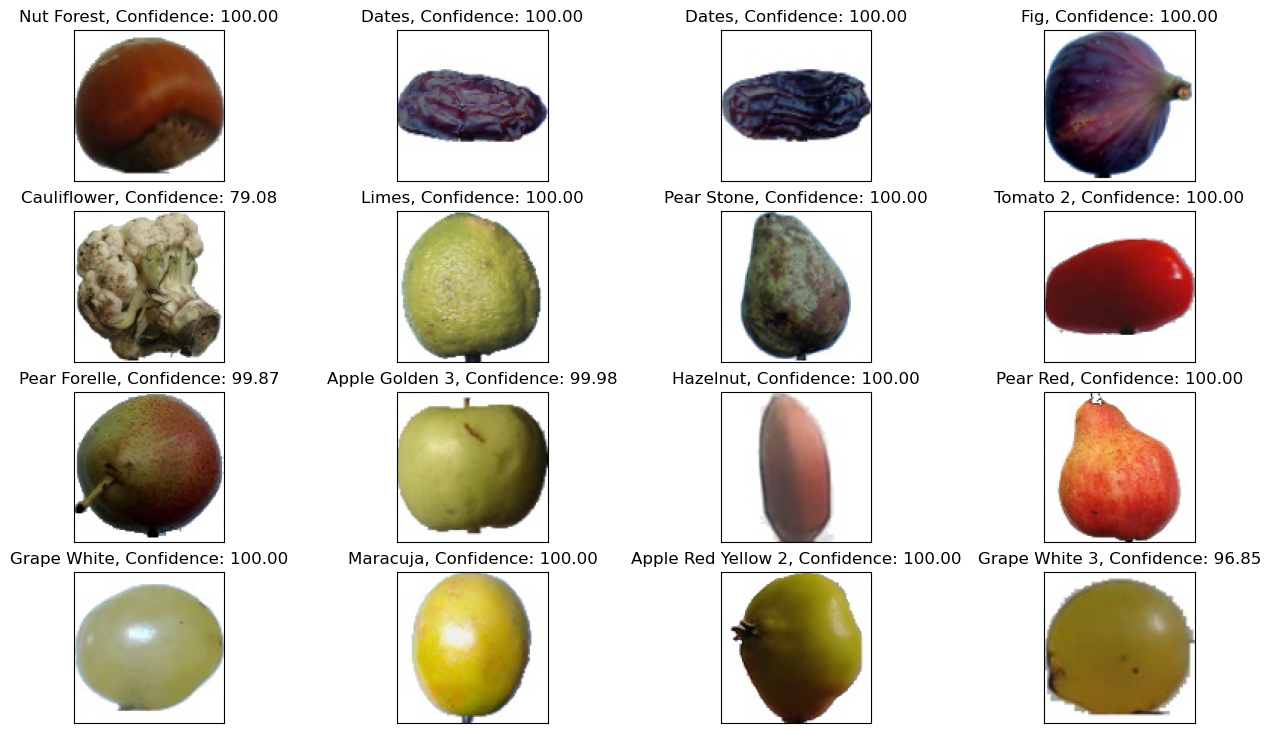

In [160]:
# Plot random images with predictions scores

fig = plt.figure(figsize=(16, 9))
for i, idx in enumerate(np.random.choice(X_test.shape[0], size=16, replace=False)):
    ax = fig.add_subplot(4, 4, i + 1, xticks=[], yticks=[])
    ax.imshow(np.squeeze(X_test[idx]))
    pred_idx = np.argmax(predictions[idx])
    score = tf.nn.softmax(predictions[idx])
    ax.set_title("{}, Confidence: {:.2f}".format(target_labels[pred_idx], 100 * np.max(score)))

In [ ]:
# Data augmentation to avoid overfitting -> create new neural network (add dropout layer)

data_augmentation = keras.Sequential(
  [
    layers.RandomFlip("horizontal_and_vertical",
                      input_shape=(img_height,
                                  img_width,
                                  3)),
    layers.RandomRotation(0.2),
    layers.RandomZoom(0.2),
  ]
)

model = Sequential([
  data_augmentation,
  layers.Rescaling(1./255, input_shape=(img_height, img_width, 3)),
  layers.Conv2D(16, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Dropout(0.2),
  layers.Flatten(),
  layers.Dense(128, activation='relu'),
  layers.Dense(num_classes, name="outputs")
])

model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

model.summary()

In [ ]:
# Increase epochs - training stops 

history = model.fit(
  X_train,
  y_train,
  batch_size = 32,
  epochs = 10,
  validation_data = (X_valid, y_valid),
  verbose = 1 
)


In [ ]:
model.save('../models/cnn-data-augmented') # Save model

In [ ]:
# Train model on bananas and evalute it on the test set -- does not work
bananas_dir = os.path.join(train_dir, 'Banana')

bananas_dir = pathlib.Path(bananas_dir)

X_train, y_train, target_labels = load_fruits360(bananas_dir)
X_test, y_test, _ = load_fruits360(test_dir)

X_train.shape